In [1]:
from glob import glob
import os
from pathlib import Path

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np

from scipy.stats import wilcoxon
import pingouin as pg

from thoi.measures.gaussian_copula import nplets_measures

rcParams = {
    'axes.titlesize': 14,
    'axes.labelsize': 20,
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'legend.fontsize': 16,
    'lines.linewidth': 2,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial']
}
sns.set_context("paper", font_scale=2, rc=rcParams)

state_colors = {
    'Awake': sns.color_palette()[2],
    'Deep': sns.color_palette()[4]
}

data_folder = Path('../data/fmri_anesthesia/42003_2023_5063_MOESM3_ESM/nets_by_subject')
result_folder = Path('../results/anesthesia')

w: 411,51019
h: 299,21558

Arial 
title: 30
label: 27
ax title: 23
ax tick label: 20
ax tick: 17

Segments: 25

In [2]:
# plot version of the libraries

print(' --- Library versions ---\n')
print('\t- Pandas version:', pd.__version__)
print('\t- Seaborn version:', sns.__version__)
print('\t- Numpy version:', np.__version__)
print('\t- Pingouin version:', pg.__version__)
print('\t- Matplotlib version:', plt.matplotlib.__version__)
print('\t- Scipy version:', wilcoxon.__module__)
print('\n ------------------------ ')

 --- Library versions ---

	- Pandas version: 2.2.3
	- Seaborn version: 0.13.2
	- Numpy version: 2.2.3
	- Pingouin version: 0.5.5
	- Matplotlib version: 3.10.1
	- Scipy version: scipy.stats._morestats

 ------------------------ 


In [3]:
states_all = ['Awake', 'Deep']

dfs_dict = {}
for state in states_all:
    # list all folder in root/state
    folders = glob(str(data_folder / state / '*'))
    for folder in folders:
        network = os.path.basename(folder).replace('_parcellation_5', '')
        
        # List all csv files in folder
        csv_files = glob(os.path.join(folder, f'ts_{network}_parcellation_5_Sub*.csv'))
        for csv_file in csv_files:
            sub = int(os.path.basename(csv_file).split('_')[-1].split('.')[0].replace('Sub', ''))
            
            # Read csv file and add information columns
            df = pd.read_csv(csv_file, sep=',', header=None)
            
            # Convert the columns in multilavel, add the network to a second lavel
            df.columns = pd.MultiIndex.from_product([[network], range(df.shape[1])])
            
            # Add df to dfs dict
            if sub not in dfs_dict:
                dfs_dict[sub] = {}
            
            if state not in dfs_dict[sub]:
                dfs_dict[sub][state] = []
            
            dfs_dict[sub][state].append(df)

# Concatenate all dataframes into a single one
dfs_list = []
for sub, states in dfs_dict.items():
    for state, dfs in states.items():
        df = pd.concat(dfs, axis=1)
        df['sub'] = sub
        df['state'] = state
        df = df[[('sub',''), ('state','')] + [col for col in df.columns if col[0] not in ['sub', 'state']]]
        dfs_list.append(df)

df = pd.concat(dfs_list, axis=0)

# Remove sub10 that has no some missing networks
df = df[df['sub'] != 10]

# Check Show missing values (should be none), all subjects have all the networks
assert df.isnull().sum().sum() == 0, 'There are missing values'

# Check all subjects have same lenght across states and networks
assert df.groupby(['sub','state']).size().unique() == [245], 'Series lenght is not the same for all subjects'

networks = df.columns.get_level_values(0).unique()[2:]
#network_pairs = list(combinations(networks, 2))

# Create the list of datsa
Xs = [
    df[(df['sub'] == sub) & (df['state'] == state)][networks].values
    for state in states_all
    for sub in sorted(df['sub'].unique())
]

Xs_awake = Xs[:16]
Xs_deep = Xs[16:]

df_columns = np.array([tuple(col) for col in df[networks].columns])

print(' --- Networks ---\n')
print('\n'.join(networks))
print('\n ------------------------ ')

display(df)

 --- Networks ---

VentralAttn
CinguloParie
Visual
SMmouth
SMhand
CinguloOperc
RetrosplenialTemporal
Default
Auditory
DorsalAttn
FrontoParietal

 ------------------------ 


sub  state VentralAttn                         CinguloParie              \
                         0     1     2     3     4            0     1     2   
0    12  Awake       -0.26  0.50  0.36  0.12  0.33        -0.04 -0.14 -0.03   
1    12  Awake       -0.56  0.01 -0.13  0.15 -0.23         0.75 -0.56 -0.79   
2    12  Awake       -0.67  0.34 -0.18  0.26  0.13         1.09 -0.53 -0.67   
3    12  Awake       -0.64  1.28  0.22  0.49  1.32         0.93 -0.02  0.26   
4    12  Awake       -0.62  1.77  0.69  0.75  2.35         0.58  0.54  1.12   
..   ..    ...         ...   ...   ...   ...   ...          ...   ...   ...   
240   5   Deep       -0.45 -0.27  1.06  0.55  1.01        -2.20  0.66 -0.26   
241   5   Deep        0.08 -0.07  1.26  0.46  1.48        -2.35  0.96  0.28   
242   5   Deep        0.68  0.01  0.91  0.11  1.36        -1.73  0.92  0.93   
243   5   Deep        0.68  0.01  0.37 -0.17  0.78        -0.86  0.57  0.88   
244   5   Deep       -0.00  0.01 -0.09 -0.24  0.02        -0.10  0.04  0.05   

     ... DorsalAttn                         FrontoParietal                    \
     ...          0     1     2     3     4              0     1     2     3   
0    ...      -0.02  0.20 -0.14  0.08  0.07           0.27  0.07  0.13  0.16   
1    ...      -0.81 -1.36 -1.52 -0.71  0.13          -1.06 -1.06 -0.32  0.31   
2    ...      -0.98 -2.05 -2.35 -1.16  0.09          -1.40 -1.42 -0.30  0.44   
3    ...      -0.45 -1.66 -2.36 -1.11  0.04          -0.60 -0.86  0.19  0.56   
4    ...       0.29 -0.70 -1.70 -0.65  0.21           0.58  0.07  0.75  0.71   
..   ...        ...   ...   ...   ...   ...            ...   ...   ...   ...   
240  ...       1.32  0.23  0.24  2.04  2.31          -1.43 -0.39 -0.10  0.85   
241  ...       0.83  0.44  0.48  2.47  1.45          -0.77 -0.36 -0.12  0.59   
242  ...      -0.10  0.22  0.54  1.88  0.17           0.09 -0.16 -0.13  0.09   
243  ...      -0.46 -0.07  0.34  0.89 -0.38           0.37  0.01 -0.13 -0.17   
244  ...      -0.06 -0.22 -0.06 -0.01 -0.02          -0.00  0.08 -0.14 -0.10   

           
        4  
0   -0.23  
1   -0.90  
2   -1.31  
3   -1.32  
4   -0.95  
..    ...  
240 -1.40  
241 -1.30  
242 -0.59  
243 -0.04  
244  0.09  

[7840 rows x 57 columns]

# Greedy MaxMin by order of interaction

In [4]:
solution_greedy_max = np.load(result_folder / 'nplets_greedy_effect_size_max.npy')
scores_greedy_max = np.load(result_folder / 'scores_greedy_effect_size_max.npy')

solution_greedy_min = np.load(result_folder / 'nplets_greedy_effect_size_min.npy')
scores_greedy_min = np.load(result_folder / 'scores_greedy_effect_size_min.npy')

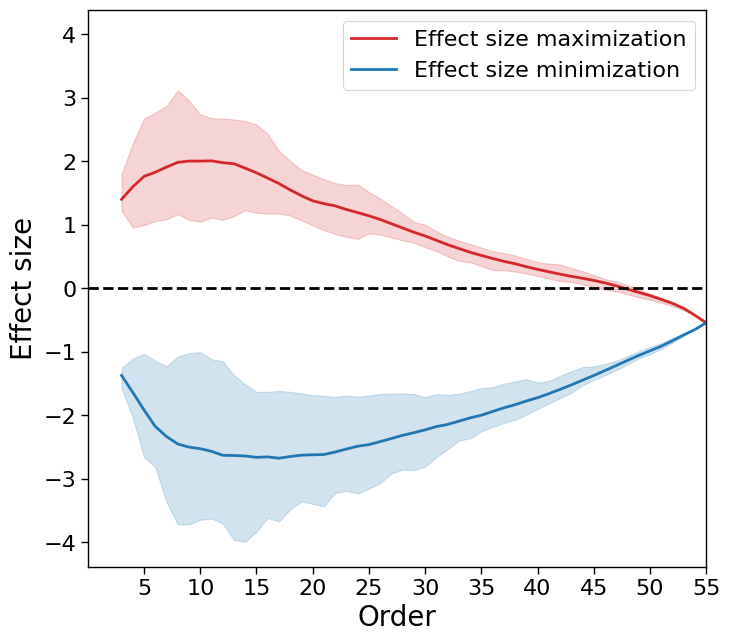

In [5]:
# Plot effect size maximization
best_order = scores_greedy_max.mean(axis=0).argmax()+3
max_score = scores_greedy_max.max()

blue = sns.color_palette()[0]
red = sns.color_palette()[3]

df_scores_greedy = pd.DataFrame([
    (o+3, r, scores_greedy_max[r, o])
    for o in range(scores_greedy_max.shape[1])
    for r in range(scores_greedy_max.shape[0])
], columns=['order', 'repeat', 'score'])

fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

sns.lineplot(
    x=df_scores_greedy['order'],
    y=df_scores_greedy['score'],
    data=df_scores_greedy,
    dashes=False, 
    label='Effect size maximization',
    errorbar=lambda x: (x.min(), x.max()),
    color=red,
    ax=ax
)

# Plot effect size minimization
best_order = scores_greedy_min.mean(axis=0).argmin()+3
min_score = scores_greedy_min.min()

df_scores_greedy = pd.DataFrame([
    (o+3, r, scores_greedy_min[r, o])
    for o in range(scores_greedy_min.shape[1])
    for r in range(scores_greedy_min.shape[0])
], columns=['order', 'repeat', 'score'])

sns.lineplot(
    x=df_scores_greedy['order'],
    y=df_scores_greedy['score'],
    data=df_scores_greedy,
    dashes=False,
    label='Effect size minimization',
    errorbar=lambda x: (x.min(), x.max()),
    color=blue,
    ax=ax
)


# Make y limits symetric
max_score = max(max_score, -min_score)* 1.1
ax.set_ylim(-max_score, max_score)

# plot zero line
ax.axhline(0, color='black', linestyle='--')

# Plot the best order for the maximization
ax.set_xlim(0,df_scores_greedy['order'].max())

ax.set_xlabel('Order')
ax.set_ylabel('Effect size')
ax.set_xticks(np.arange(5, 56, 5))

plt.tight_layout()
plt.show()

In [6]:
def plot_contrast(Xs, nplet, metric = 'o', text_left=True, text_top=False):
    
    # Size to fit 4 instead of 3 horizontal
    fig, ax = plt.subplots(figsize=(4.8, 5.1))
    
    order = nplet.shape[0]
    metric_idx = ['dtc', 'tc', 'o', 's'].index(metric)
    
    o = nplets_measures(Xs, nplet.reshape(1, -1))[0, :, metric_idx]

    x = o[:len(o) // 2]
    y = o[len(o) // 2:]

    pval = wilcoxon(x, y, alternative='two-sided').pvalue
    effect_size = pg.compute_effsize(y, x, eftype='cohen') # x and y inverted to have deep - awake

    df_greedy_best = pd.DataFrame({
        'o': o,
        'subject': np.concatenate([np.arange(16), np.arange(16)]),
        'state': np.concatenate([np.repeat('Awake', 16), np.repeat('Deep', 16)])
    })

    # Plot violin plots of the best nplets with state in the x acess and o in the y axis
    sns.violinplot(
        data=df_greedy_best,
        x='state',
        y='o',
        cut=0,
        alpha=0.5,
        palette=state_colors,
        legend=False,
        ax=ax
    )

    # add stripplot and connect the dots between the same subjects
    sns.stripplot(
        data=df_greedy_best,
        x='state',
        y='o',
        jitter=False,          # Disable jitter for alignment
        size=8,
        palette=state_colors,
        edgecolor='auto',
        alpha=0.7,
        ax=ax
    )

    # Connect each subject's paired measurements with lines
    for subject, subject_data in df_greedy_best.groupby('subject'):
        subject_data = subject_data.sort_values('state')
        plt.plot(
            subject_data['state'],
            subject_data['o'],
            marker='o',
            color='black',
            alpha=0.5,
            linewidth=1
        )

    ax.set_xlabel('State')
    ax.set_ylabel('')
    
    textstr = f'Order: {order}\np: {pval:.2e}\nd: {effect_size:.2f}'

    # Add the text to the plot
    ax.text(0.05 if text_left else 0.5,
            0.95 if not text_top else 1.25,
            textstr,
            transform=ax.transAxes,
            fontsize=18,
            verticalalignment='top')

    n_states = 2 # Awake and Deep
    plt.xlim(-0.5, n_states - 0.5)


# Greedy contrast

-- Greedy maximization n-plet regions --



,Network,Region
0,CinguloOperc,0
1,Default,0
2,FrontoParietal,1
3,DorsalAttn,2
4,SMmouth,3
5,Auditory,2
6,FrontoParietal,2
7,VentralAttn,3


/tmp/ipykernel_598513/1948896456.py:24: FutureWarning:   

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_598513/1948896456.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


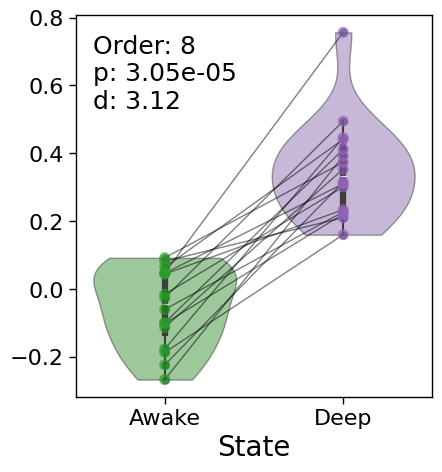


-- Greedy minimization n-plet regions --



,Network,Region
0,CinguloOperc,2
1,CinguloOperc,3
2,DorsalAttn,3
3,Default,1
4,CinguloParie,2
5,CinguloOperc,1
6,Visual,1
7,Default,4
8,FrontoParietal,0
9,CinguloParie,0


/tmp/ipykernel_598513/1948896456.py:24: FutureWarning:   

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_598513/1948896456.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


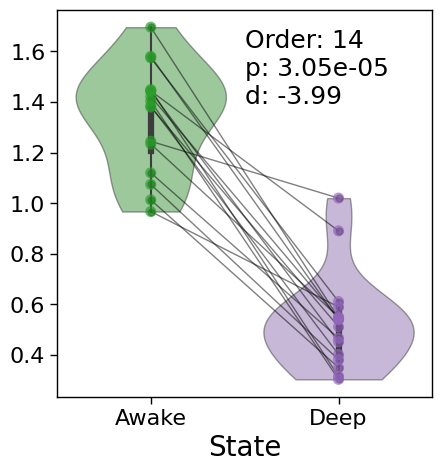

In [7]:
best_order_max = scores_greedy_max.max(axis=0).argmax()+3
best_repeat_max = scores_greedy_max[:, best_order_max-3].argmax()
nplet_best_max = solution_greedy_max[best_repeat_max,:best_order_max]

best_order_min = scores_greedy_min.min(axis=0).argmin()+3
best_repeat_min = scores_greedy_min[:, best_order_min-3].argmin()
nplet_best_min = solution_greedy_min[best_repeat_min,:best_order_min]

print('-- Greedy maximization n-plet regions --\n')
display(pd.DataFrame(df_columns[nplet_best_max], columns=['Network', 'Region']))

plot_contrast(Xs, nplet_best_max)
plt.tight_layout()
plt.show()

print('\n-- Greedy minimization n-plet regions --\n')
display(pd.DataFrame(df_columns[nplet_best_min], columns=['Network', 'Region']))

plot_contrast(Xs, nplet_best_min, text_left=False)
plt.tight_layout()
plt.show()

# Multi order annealing

In [8]:
solution_annealing_multi_order_max = np.load(result_folder / 'nplets_annealing_effect_size_max.npy')
scores_annealing_multi_order_max = np.load(result_folder / 'scores_annealing_effect_size_max.npy')

solution_annealing_multi_order_min = np.load(result_folder / 'nplets_annealing_effect_size_min.npy')
scores_annealing_multi_order_min = np.load(result_folder / 'scores_annealing_effect_size_min.npy')

-- Simulated annealing maximization --



,Network,Region
0,VentralAttn,0
1,VentralAttn,3
2,CinguloParie,1
3,CinguloParie,3
4,Visual,3
5,Visual,4
6,RetrosplenialTemporal,1
7,RetrosplenialTemporal,2
8,Default,0
9,DorsalAttn,1


/tmp/ipykernel_598513/1948896456.py:24: FutureWarning:   

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_598513/1948896456.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


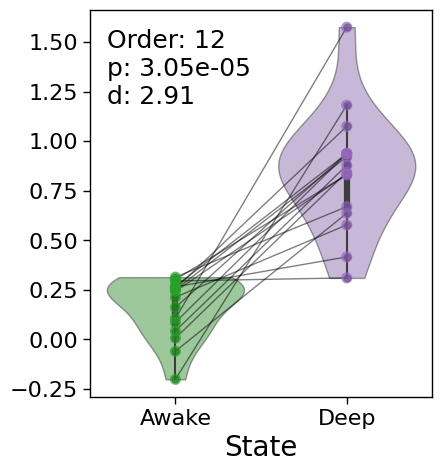


-- Simulated annealing minimization --



,Network,Region
0,CinguloParie,0
1,CinguloParie,2
2,CinguloParie,3
3,CinguloParie,4
4,Visual,1
5,SMhand,3
6,CinguloOperc,0
7,CinguloOperc,2
8,CinguloOperc,3
9,CinguloOperc,4


/tmp/ipykernel_598513/1948896456.py:24: FutureWarning:   

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_598513/1948896456.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


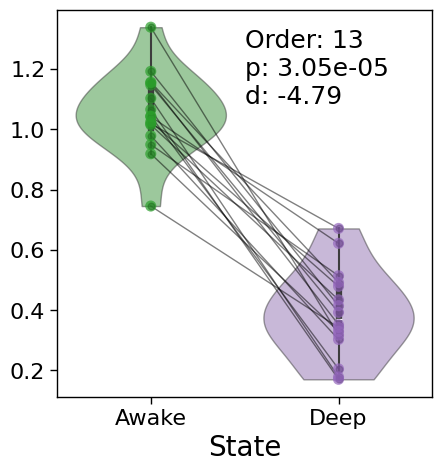

In [9]:
nplet_best_max = solution_annealing_multi_order_max[scores_annealing_multi_order_max.argmax()]
nplet_best_max = np.where(nplet_best_max)[0]

nplet_best_min = solution_annealing_multi_order_min[scores_annealing_multi_order_min.argmin()]
nplet_best_min = np.where(nplet_best_min)[0]

print('-- Simulated annealing maximization --\n')
display(pd.DataFrame(df_columns[nplet_best_max], columns=['Network', 'Region']))

plot_contrast(Xs, nplet_best_max)

plt.tight_layout()
plt.show()

print('\n-- Simulated annealing minimization --\n')
display(pd.DataFrame(df_columns[nplet_best_min], columns=['Network', 'Region']))

plot_contrast(Xs, nplet_best_min, text_left=False)
plt.tight_layout()
plt.show()


# Whole brain contrast

-- All n-plet regions --



,Network,Region
0,VentralAttn,0
1,VentralAttn,1
2,VentralAttn,2
3,VentralAttn,3
4,VentralAttn,4
5,CinguloParie,0
6,CinguloParie,1
7,CinguloParie,2
8,CinguloParie,3
9,CinguloParie,4


/tmp/ipykernel_598513/1948896456.py:24: FutureWarning:   

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/tmp/ipykernel_598513/1948896456.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(


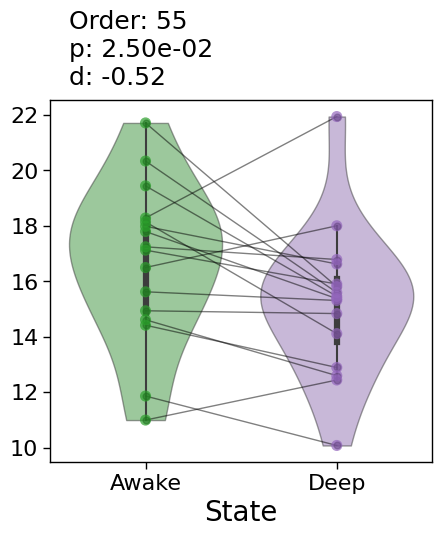

In [10]:
nplet_all = np.arange(55).reshape(1,-1)

print('-- All n-plet regions --\n')
display(pd.DataFrame(df_columns, columns=['Network', 'Region']))

plot_contrast(Xs, np.arange(55), text_top=True)

# set fig size
plt.gcf().set_size_inches(4.8, 6)


plt.tight_layout()
plt.show()

# Whale plot


In [11]:
nplets_greedy_awake_max = np.load(result_folder / 'nplets_greedy_awake_max.npy')
scores_greedy_awake_max = np.load(result_folder / 'scores_greedy_awake_max.npy')

nplets_greedy_awake_min = np.load(result_folder / 'nplets_greedy_awake_min.npy')
scores_greedy_awake_min = np.load(result_folder / 'scores_greedy_awake_min.npy')

nplets_greedy_deep_max = np.load(result_folder / 'nplets_greedy_deep_max.npy')
scores_greedy_deep_max = np.load(result_folder / 'scores_greedy_deep_max.npy')

nplets_greedy_deep_min = np.load(result_folder / 'nplets_greedy_deep_min.npy')
scores_greedy_deep_min = np.load(result_folder / 'scores_greedy_deep_min.npy')

In [12]:
def greedy_to_df(scores, label):
    
    if 'Max' in label:
        best_score = scores.max(axis=0)
    else:
        best_score = scores.min(axis=0)

    orders = np.arange(3, 56)
    
    return pd.DataFrame({
        'order': orders,
        'label': label,
        'o': best_score
    })
    
df_greedy_awake_max = greedy_to_df(scores_greedy_awake_max, 'Awake Greedy Max')
df_greedy_awake_min = greedy_to_df(scores_greedy_awake_min, 'Awake Greedy Min')
df_greedy_deep_max = greedy_to_df(scores_greedy_deep_max, 'Deep Greedy Max')
df_greedy_deep_min = greedy_to_df(scores_greedy_deep_min, 'Deep Greedy Min')

df_whale = pd.concat([
    df_greedy_awake_max,
    df_greedy_awake_min,
    df_greedy_deep_max,
    df_greedy_deep_min
])

In [13]:
def plot_whale_curve(df, state, ax):
    
    # get the blue and orange seaborn default colors
    color = state_colors[state]
    
    df_state = df[df['label'].str.contains(state)]

    # Plot the greedy search results 
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Max')],
        color=color,
        label=rf'$Greedy(\Omega({state}))$',
        ax=ax
    )
    sns.lineplot(
        x='order',
        y='o',
        data=df_state[df_state['label'].str.contains('Greedy Min')],
        color=color,
        ax=ax
    )

    plt.fill_between(
        df_state[df_state['label'].str.contains('Greedy Min')]['order'],
        df_state[df_state['label'].str.contains('Greedy Min')]['o'],
        df_state[df_state['label'].str.contains('Greedy Max')]['o'],
        alpha=0.2, color=color,
    )

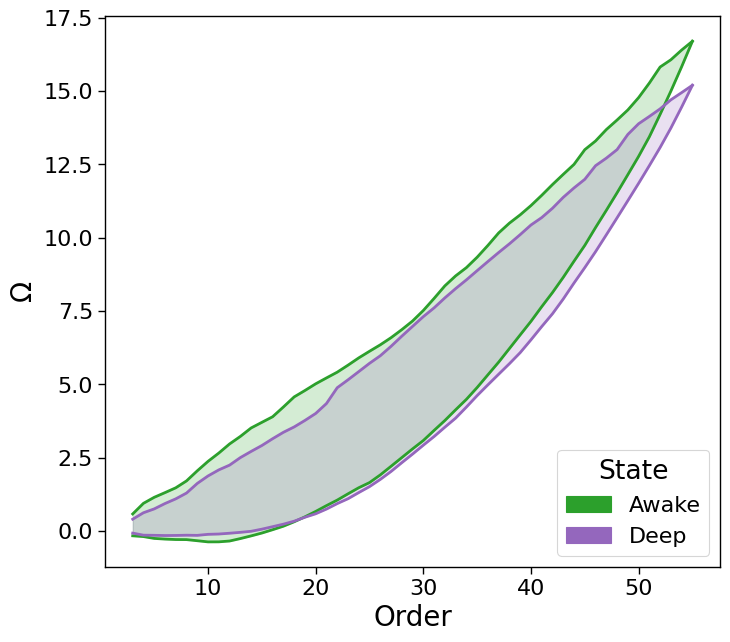

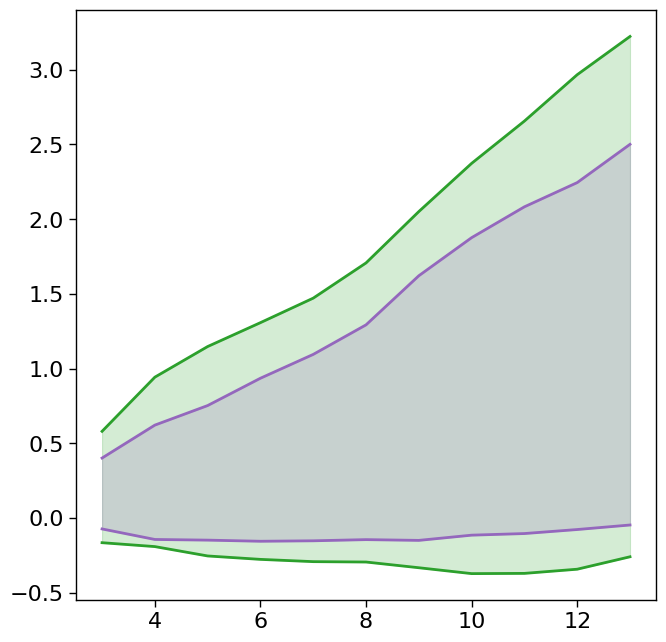

In [14]:
fig, ax = plt.subplots(figsize=(1.2*6.4, 6.8))

plot_whale_curve(df_whale, 'Awake', ax)
plot_whale_curve(df_whale, 'Deep', ax)

ax.get_legend().remove()

# add une legends with two filled squared blue and orange with labels ['Awake', 'Deep']
state_legend = plt.legend(
    handles=[
        Patch(facecolor=state_colors['Awake'], edgecolor=state_colors['Awake'], label='Awake'),
        Patch(facecolor=state_colors['Deep'], edgecolor=state_colors['Deep'], label='Deep')
    ],
    labels=['Awake', 'Deep'],
    title='State',
    loc='lower right'
)

plt.xlabel('Order')
plt.ylabel(r'$\Omega$')

plt.tight_layout()
plt.show()


# Plot the zoomed inset of the whale plot
fig, ax = plt.subplots(figsize=(1.1*6.4, 6.8))

plot_whale_curve(df_whale[df_whale['order'] < 14], 'Awake', ax)
plot_whale_curve(df_whale[df_whale['order'] < 14], 'Deep', ax)

ax.get_legend().remove()

plt.xlabel('')
plt.ylabel('')

plt.tight_layout()
plt.show()